# Basic ML Models

## Load Dataset

In [1]:
import numpy as np
import pandas as pd

In [3]:
info_df = pd.read_csv('data/info_df.csv')
utterance_df = pd.read_csv('data/utterance_features.csv')
smile_df = pd.read_csv('data/smile_features_silence_removed.csv')

# Drop the specified columns from combined_df
columns_to_drop = ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 
                   'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']

merged_df = info_df.merge(utterance_df, on='Participant_ID').merge(smile_df, on='Participant_ID')

df = merged_df.drop(columns=columns_to_drop)

smile_columns = smile_df.columns[1:].tolist()
utterance_columns = utterance_df.columns[1:].tolist()

### Check missing data and remove the missing columns

In [4]:
missing_columns = df.columns[df.isnull().any()]
print("Columns with missing values:", missing_columns.tolist())
for col in missing_columns:
    missing_count = df[col].isnull().sum()
    print(f"Column '{col}' has {missing_count} missing values.")

missing_split_values = df[df[missing_columns].isnull().any(axis=1)]['Split']
print("Split values for rows with missing values:", missing_split_values.tolist())

# drop columns with missing values
df = df.drop(columns=missing_columns)
utterance_columns = [col for col in utterance_columns if col not in missing_columns]

all_columns = smile_columns + utterance_columns

Columns with missing values: ['Avg_Utterance_Duration_Ellie', 'Avg_Word_Count_Ellie']
Column 'Avg_Utterance_Duration_Ellie' has 3 missing values.
Column 'Avg_Word_Count_Ellie' has 3 missing values.
Split values for rows with missing values: ['dev', 'dev', 'test']


## Run ML models

In [5]:
from src.evaluate_ml_models import MLPipeline
from src.evaluate_ml_models import set_seed_everything
set_seed_everything(42)

pipeline = MLPipeline(df, feature_cols=all_columns)
result, report = pipeline.evaluate_models(baseline=True, report=True)
display(result)

,Model,Accuracy,F1(macro),AUROC,Precision,Recall
0,Baseline (Majority Voting),0.702128,0.412500,0.500000,0.351064,0.500000
1,SVM,0.531915,0.440476,0.640693,0.440476,0.440476
2,KNN,0.595745,0.373333,0.362554,0.333333,0.424242
3,RandomForest,0.680851,0.461421,0.571429,0.518939,0.505411
4,LogisticRegression,0.595745,0.506357,0.458874,0.506787,0.506494
5,GradientBoosting,0.680851,0.540117,0.593074,0.576786,0.546537
6,XGBoost,0.702128,0.584596,0.508658,0.621795,0.582251


### Result Visualization

Baseline found...


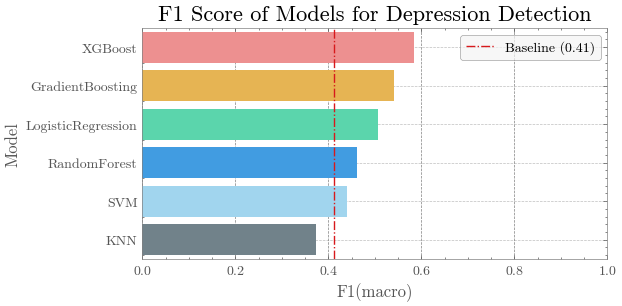

Baseline found...


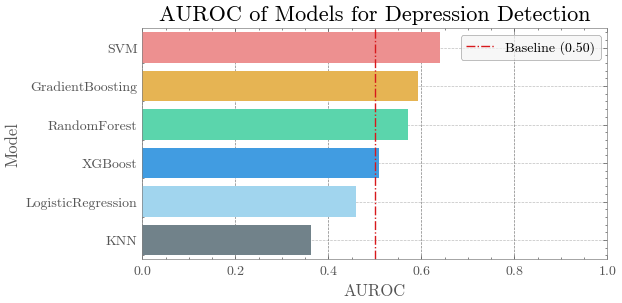

In [9]:
from src import plot_result, plot_cm
import os
os.makedirs("results/silence_removed_result", exist_ok=True)

plot_result(result, metric='F1(macro)', sort=True, title="F1 Score of Models for Depression Detection", save_path="results/silence_removed_result/feature_all_model_ml_metric_f1.png")
plot_result(result, metric='AUROC', sort=True, title="AUROC of Models for Depression Detection", save_path="results/silence_removed_result/feature_all_model_ml_metric_auroc.png")

In [10]:
from sklearn.metrics import confusion_matrix

classified_result = report['XGBoost']['per_sample']
classified_result = classified_result.merge(
    df[['Participant_ID', 'Gender']],
    on='Participant_ID',
    how='left'
)
classified_result['GENDER'] = classified_result['Gender'].apply(lambda x: 'F' if x == 0 else 'M')

conf_matrices_by_gender = {}
for gender in ['F', 'M']:
    subset = classified_result[classified_result['GENDER'] == gender]
    cm = confusion_matrix(subset['True Label'], subset['Predicted Label'], labels=[0, 1])
    conf_matrices_by_gender[gender] = cm
conf_matrices_by_gender

{'F': array([[13,  4],
        [ 4,  3]], dtype=int64),
 'M': array([[16,  0],
        [ 6,  1]], dtype=int64)}

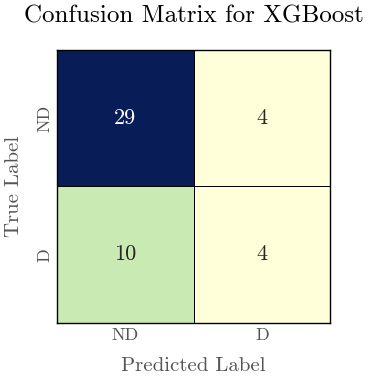

In [ ]:
plot_cm(report['XGBoost']['confusion_matrix'], title="Confusion Matrix for XGBoost", save_path="results/silence_removed_result/cm_feature_all_xgb.png")